In [1]:
import time
import timeit
from IPython import display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

from itertools import cycle, islice
from math import ceil
from tqdm import tqdm
from ard_em import GaussianMixtureARD
import h5py
import shutil

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(10)
%matplotlib inline

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Подготовим данные

In [2]:
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
data = pd.read_csv('../../../SUSY.csv', header=None, names=column_names)

In [3]:
data.head()

,label,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [4]:
data.shape

(5000000, 19)

Делим выборку на признаки и таргеты. Нормируем признаки.

$X_{new} = \frac{X - \mu}{\sigma}$

In [5]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

In [6]:
min_class_size = min(X_data[np.where(labels==0)[0]].shape[0], X_data[np.where(labels==1)[0]].shape[0])

In [7]:
min_class_size

2287827

In [8]:
X_0 = X_data[np.where(labels==0)[0]]
X_1 = X_data[np.where(labels==1)[0]]

In [9]:
np.concatenate((X_0[:min_class_size], X_1[:min_class_size])).shape

(4575654, 18)

In [10]:
X_data = np.concatenate((X_0[:min_class_size], X_1[:min_class_size]))
labels = np.concatenate((np.zeros((min_class_size,1)), np.ones((min_class_size,1)))).ravel()

Разбиваем на train(8% от всех данных) и test(2%)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), 
                                         stratify=labels, train_size=400000, test_size=100000, random_state=5)

In [13]:
indx_train = np.random.permutation(indx_train)
indx_test = np.random.permutation(indx_test)

In [14]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

Разбиваем объекты по классам

In [15]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [16]:
X_good.shape, X_train.shape, X_data.shape

((200000, 18), (400000, 18), (4575654, 18))

## Сгенерируем примеры используя GMM подход

In [17]:
gm = GaussianMixture(n_components=35, n_init=4, covariance_type="full", verbose=0)

In [18]:
%%time
sigma = 0.01
gm.fit(X_good + np.random.normal(0, sigma, X_good.shape))

CPU times: user 23min 33s, sys: 5min 57s, total: 29min 31s
Wall time: 29min 29s


In [19]:
gm.bic(X_good)

-112496.9081242989

Генерируем выборку размера исходной нейтральной следующим образом:
- Для каждой компоненты смеси распределения, сэмплируем свои примеры с востановленными матожиданием и матрицей ковариаций
- Количество примеров для компоненты пропорционально ее вкладу в смесь

In [20]:
from scipy.stats import multivariate_normal

In [21]:
n_samples = X_good.shape[0] * 5

In [22]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], 
                                       size=ceil(gm.weights_[0]*n_samples)))
for d in range(1, gm.n_components):
    gen=np.vstack((
        gen, multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=ceil(gm.weights_[d]*n_samples))
    ))
np.random.shuffle(gen)
gen = np.array(gen)[:n_samples]

Посчитаем плотности вероятности на сгенерированных объектах для каждой компоненты смеси

In [23]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [24]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], cov=gm.covariances_[d], allow_singular=True)

In [25]:
gen.shape

(1000000, 18)

Выберем для каждого объекта наибольшую вероятность по всем компонентам и инвертируем это значение для получения веса

Т.е. нам интересны те примеры, которые мало вероятно появляются в восстановленной смеси распределения(необычное поведение == аномалия)

In [26]:
maxprob = np.max(probabilities, axis=0)
gen_w = 1./(maxprob + 1e-2)

Веса ограничены сверху 100. Из этого графика мало что понятно, так как точек слигком много. Можно сказаль лишь то, что около граничных значений весов точек намного больше, чем в середине.

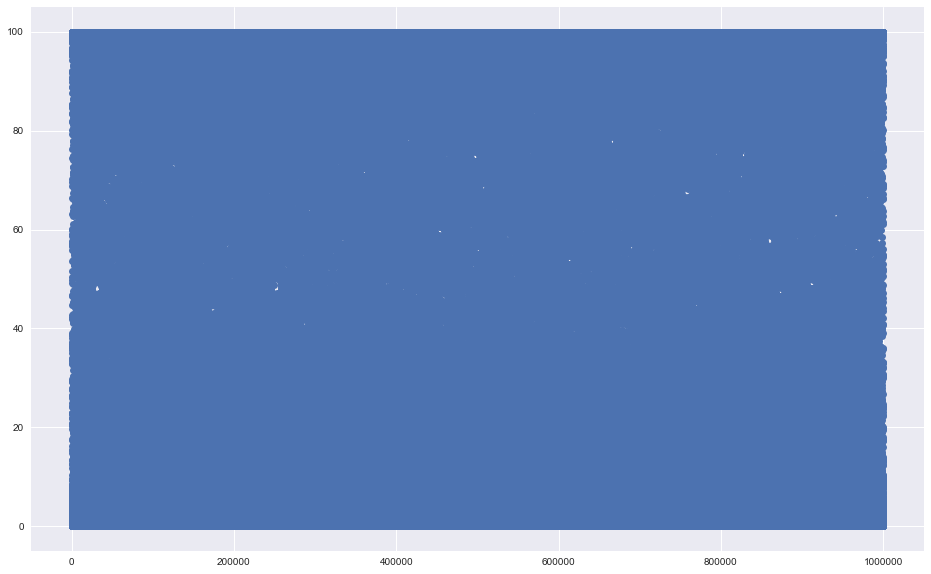

In [27]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(gen_w)), gen_w, linewidths=0.00001)
plt.show()

Нормируем полученные веса

In [28]:
weights = np.ones((n_samples, 1)) #X_train.shape[0]

In [29]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [30]:
gen_w_normed.sum(), np.sum(weights)

(1000000.0000000005, 1000000.0)

In [31]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [32]:
X_mix = np.vstack((gen, X_good)) 

y_mix = np.vstack((y2, y1))

weights_mix = np.vstack((gen_w_normed.reshape(-1,1), weights.reshape(-1,1))).reshape(-1)

In [33]:
weights_mix.shape, y_mix.shape

((2000000,), (2000000, 1))

In [34]:
X_gen = gen
y_gen = np.ones((X_gen.shape[0],1))

weights_gen = gen_w_normed.reshape(-1)

In [35]:
w_gen = weights_gen

## Обучим на этом нейронку

Строит зависимость ошибок от эпохи

In [36]:
# summarize history for loss
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

In [37]:
ours_roc_aucs = {}
ours_pr_aucs = {}
ours_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

Реализуем функции для вычисления precision at recall

In [38]:
def p_at_r(y_test, y_pred, x):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    return max(precision[recall > x])

In [39]:
def _eval_p_at_rs(y_test, y_pred, frac, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        if descr in ours_p_at_r[recall]:
            # append the new number to the existing array at this slot
            ours_p_at_r[recall][descr].append((frac, p_at_r(y_test, y_pred, float(recall))))
        else:
            # create a new array in this slot
            ours_p_at_r[recall][descr] = [(frac, p_at_r(y_test, y_pred, float(recall)))]
            
def _eval_p_at_rs_flatten(y_test, y_pred, frac, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        ours_p_at_r[recall][descr] = (frac, p_at_r(y_test, y_pred, float(recall)))

Посмотрим на значения весов объектов в объединенной выборке

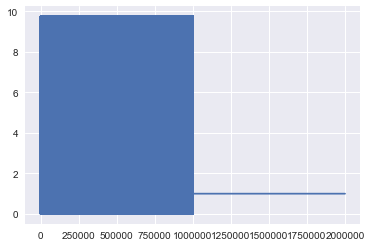

In [40]:
plt.plot(weights_mix)
plt.show()

Сохранение метрик

In [41]:
import json

def dump(saved_dict, folder, name):
    dict_for_json = {k: {kk: list(vv) for kk, vv in v.items()} if isinstance(v, dict) else list(v) 
                     for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json
    
def create_metrics_folder(metrics_path):
    if not os.path.exists(metrics_path):
        os.makedirs(metrics_path)
    try:
        last_folder_n = max(list(map(lambda name: int(name), 
                                     filter(lambda name: os.path.isdir(os.path.join(metrics_path, name)) 
                                            and name.isdecimal(), os.listdir(metrics_path)))))
    except:
        last_folder_n = 0
    new_folder = os.path.join(metrics_path, str(last_folder_n + 1))
    old_folder = os.path.join(metrics_path, str(last_folder_n))
    os.makedirs(new_folder)    
    return new_folder, old_folder

# костыль, чтобы не сохранять разные словари отдельно
def dump_metrics(metrics_path):
    folder, old_folder = create_metrics_folder(metrics_path)
    print(folder)

    dump(ours_pr_aucs, folder, "ours_pr_aucs")
    dump(ours_roc_aucs, folder, "ours_roc_aucs")
    dump(ours_p_at_r, folder, "ours_p_at_r")
    
    shutil.rmtree(old_folder, ignore_errors=True)

Графики метрик

In [42]:
def metric_boxplot(metric, ylabel='PR_AUC', ylim=None):
    n = len(metric.keys())
    plt.figure(figsize=(15, 7 * ceil(n/2)))

    for i, clf_name in enumerate(metric.keys()):
        plt.subplot(ceil(n/2), 2, i + 1)
        sns.boxplot(np.array(metric[clf_name])[:, 0]*100, np.array(metric[clf_name])[:, 1])
        plt.ylim(ylim)
        plt.xlabel("% of used anomalies")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.title(clf_name)

А теперь сама нейронка

In [43]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '2'

In [44]:
import os
import tensorflow as tf
tf.set_random_seed(1)

import keras
from keras.models import Sequential, Model
from keras import layers as L
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [45]:
sess = tf.Session(config=config)
set_session(sess)

Простейшая сверточная сеть для двухклассовой классификации

In [46]:
def build_net(features_dim, alpha, l2=1e-5):
#     with tf.Graph().as_default():
    with tf.variable_scope('placeholders'):
        X = tf.placeholder('float32', shape=(None, features_dim), name='X')
        X_pos = tf.placeholder('float32', shape=(None, features_dim), name='X_pos')
        X_true_neg = tf.placeholder('float32', shape=(None, features_dim), name='X_true_neg')
        X_pseudo_neg = tf.placeholder('float32', shape=(None, features_dim), name='X_pseudo_neg')

        w_pos = tf.placeholder('float32', shape=(None), name='w_pos')
        w_true_neg = tf.placeholder('float32', shape=(None), name='w_true_neg')
        w_pseudo_neg = tf.placeholder('float32', shape=(None), name='w_pseudo_neg')

    tf_alpha = tf.constant(alpha, dtype='float32')

    net = Sequential()
    net.add(L.Dense(80, input_dim=features_dim, activation = 'relu', 
                    kernel_regularizer=keras.regularizers.l2(l2)))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.2))
    net.add(L.Dense(32, activation='relu', 
                    kernel_regularizer=keras.regularizers.l2(l2)))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.1))
    net.add(L.Dense(1, activation='sigmoid'))

    # loss
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        y_proba = net(X)
        y_pred = tf.round(y_proba)

        y_proba_pos = net(X_pos)
        y_proba_true_neg = net(X_true_neg)
        y_proba_pseudo_neg = net(X_pseudo_neg)
        
    loss_1 = -tf.reduce_mean(tf.multiply(w_pos, tf.log(y_proba_pos + 1e-7)))/2
    loss_2 = -tf.multiply(tf_alpha, tf.reduce_mean(tf.multiply(w_true_neg, tf.log(1 - y_proba_true_neg + 1e-7))))/2
    loss_3 = -tf.multiply((1 - tf_alpha), tf.reduce_mean(tf.multiply(w_pseudo_neg, 
                                                                     tf.log(1 - y_proba_pseudo_neg + 1e-7))))/2
    
    loss = 0
    loss += tf.cond(tf.equal(tf.reduce_prod(tf.shape(X_pos)), 0), lambda: 0., lambda: loss_1)
    loss += tf.cond(tf.equal(tf.reduce_prod(tf.shape(X_true_neg)), 0), lambda: 0., lambda: loss_2)
    loss += tf.cond(tf.equal(tf.reduce_prod(tf.shape(X_pseudo_neg)), 0), lambda: 0., lambda: loss_3)
    
    for reg_loss in net.losses:
        loss += reg_loss
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    gvs = optimizer.compute_gradients(loss)
    cliped_gvs = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gvs]
    train_step = optimizer.apply_gradients(cliped_gvs)

    return y_proba, y_pred, train_step, loss

In [47]:
def get_val_data(X_pos, X_true_neg, X_pseudo_neg, 
                 w_pos, w_true_neg, w_pseudo_neg, val_size=0.1):
    # join all datasets
    X = np.concatenate((
        X_pos,
        X_true_neg,
        X_pseudo_neg,
    ), axis=0)
    y = np.concatenate((
        np.zeros(X_pos.shape[0]),
        np.ones(X_true_neg.shape[0]),
        np.ones(X_pseudo_neg.shape[0]) * 2,
    ), axis=0)
    w = np.concatenate((
        w_pos,
        w_true_neg,
        w_pseudo_neg,
    ), axis=0)
    
    # shuffle
    idx = np.random.permutation(np.arange(y.shape[0]))
    _, idx_val = train_test_split(idx, stratify=y[idx], test_size=val_size, random_state=5)
    X_val = X[idx_val]
    y_val = y[idx_val]
    w_val = w[idx_val]
    
    X_pos_val = X_val[np.where(y_val==0)[0]]
    X_true_neg_val = X_val[np.where(y_val==1)[0]]
    X_pseudo_neg_val = X_val[np.where(y_val==2)[0]]
    w_pos_val = w_val[np.where(y_val==0)[0]]
    w_true_neg_val = w_val[np.where(y_val==1)[0]]
    w_pseudo_neg_val = w_val[np.where(y_val==2)[0]]
    
    if w_true_neg_val.size == 0:
        X_true_neg_val = X_true_neg[:1]
        w_true_neg_val = w_true_neg[:1]
    
    return X_pos_val, X_true_neg_val, X_pseudo_neg_val, w_pos_val, w_true_neg_val, w_pseudo_neg_val
    
    
def batch_generator(X_pos, X_true_neg, X_pseudo_neg, 
                    w_pos, w_true_neg, w_pseudo_neg, batch_size=256):
    max_size = max([X_pos.shape[0], X_true_neg.shape[0], X_pseudo_neg.shape[0]])

    pos_idx = np.random.permutation([i%X_pos.shape[0] for i in np.arange(max_size)])
    true_neg_idx = np.random.permutation([i%X_true_neg.shape[0] for i in np.arange(max_size)])
    pseudo_neg_idx = np.random.permutation([i%X_pseudo_neg.shape[0] for i in np.arange(max_size)])


    for i in range(0, max_size, batch_size):
        yield {
            'placeholders/X_pos:0': X_pos[pos_idx[i:i + batch_size]],
            'placeholders/X_true_neg:0': X_true_neg[true_neg_idx[i:i + batch_size]],
            'placeholders/X_pseudo_neg:0': X_pseudo_neg[pseudo_neg_idx[i:i + batch_size]],
            'placeholders/w_pos:0': w_pos[pos_idx[i:i + batch_size]],
            'placeholders/w_true_neg:0': w_true_neg[true_neg_idx[i:i + batch_size]],
            'placeholders/w_pseudo_neg:0': w_pseudo_neg[pseudo_neg_idx[i:i + batch_size]],
        }

In [48]:
# summarize losses
def loss_plot(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)
    plt.plot(x, train_loss)
    plt.plot(x, val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

In [49]:
def train_function(loss_fn, train_step_fn, 
                   X_good, X_bad, X_gen, 
                   w_good, w_bad, w_gen, 
                   s=sess, batch_size=256, val_size=0.1, n_epoches=130, verbose=1):
    train_data_tuple = X_good, X_bad, X_gen, w_good, w_bad, w_gen
    val_data_tuple = get_val_data(
        *train_data_tuple, val_size=val_size
    )
    
    train_loss = []
    val_loss = []
    for epoch in tqdm(range(1, n_epoches+1)):
        # train
        epoch_train_loss = []
        for train_dict in batch_generator(*train_data_tuple, batch_size):
            epoch_train_loss.append(s.run([loss_fn, train_step_fn], train_dict)[0])
        
        # val
        epoch_val_loss = []
        for val_dict in batch_generator(*val_data_tuple, batch_size):
            epoch_val_loss.append(s.run(loss_fn, val_dict))
        
        # loss
        train_loss.append(np.mean(epoch_train_loss))
        val_loss.append(np.mean(epoch_val_loss))
        if np.isnan(train_loss[-1]) or np.isnan(val_loss[-1]):
            print('Nan! N_epoch: {}'.format(epoch))
            return False, train_loss, val_loss
        
        # verbosity
        if verbose:
            print("Epoch: {}, train loss: {:.3f}, val loss: {:.3f}".format(
                epoch, train_loss[-1], val_loss[-1]
            ))
    return True, train_loss, val_loss

Обучим нейронку с нашими весами

In [53]:
ours_roc_aucs = {}
ours_pr_aucs = {}
ours_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

In [54]:
fraction_of_negative_used = np.array([0.001, 0.01, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.
n_resplits = np.array([20, 20, 20, 20, 4, 4, 4, 4, 4])
n_evals_for_frac = np.zeros_like(fraction_of_negative_used)

Run time: 2073.56 sec


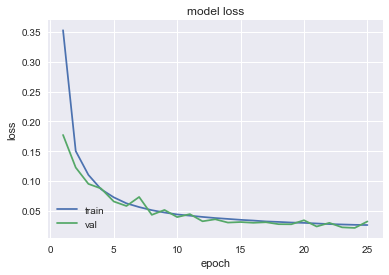

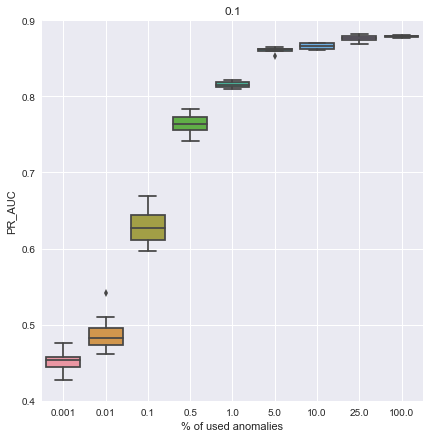

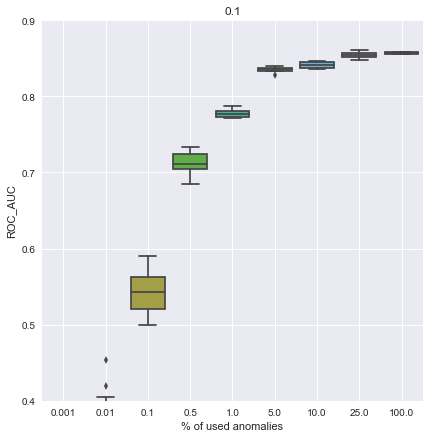

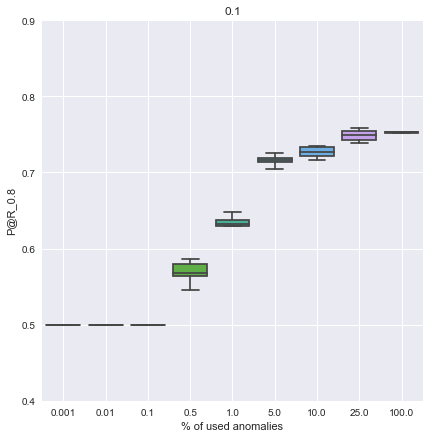

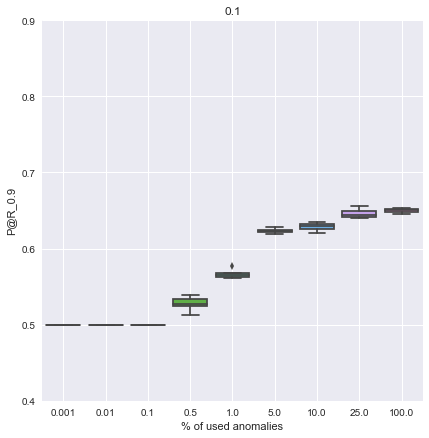

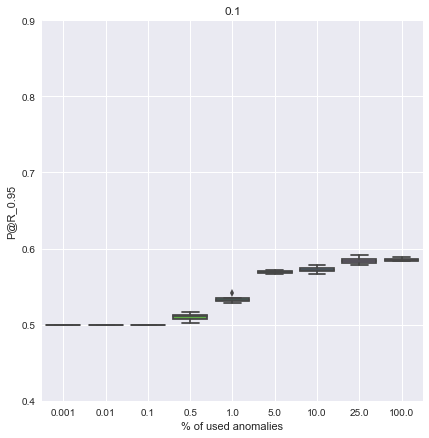

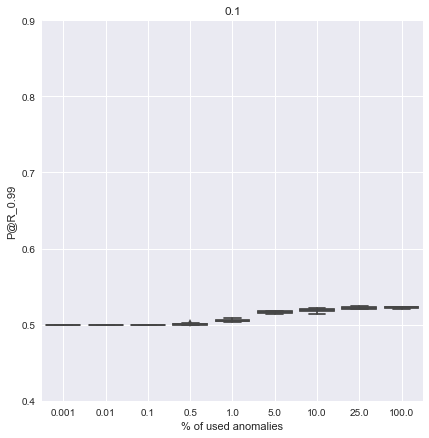

2it [37:30, 742.98s/it]

./metrics/our/alpha_0.1/459
ROC_AUC:  (0.0001, 0.39043939780000003)
alpha:  0.1
n_evals_for_frac:  [19. 16. 18. 16.  4.  4.  4.  4.  4.]
n_errors:  0



  4%|▍         | 1/25 [01:24<33:46, 84.44s/it]

Epoch: 1, train loss: 0.409, val loss: 0.208



  8%|▊         | 2/25 [02:48<32:22, 84.44s/it]

Epoch: 2, train loss: 0.175, val loss: 0.161



 12%|█▏        | 3/25 [04:12<30:54, 84.32s/it]

Epoch: 3, train loss: 0.134, val loss: 0.125



 16%|█▌        | 4/25 [05:35<29:22, 83.94s/it]

Epoch: 4, train loss: 0.115, val loss: 0.109



 20%|██        | 5/25 [06:58<27:50, 83.54s/it]

Epoch: 5, train loss: 0.102, val loss: 0.097



 24%|██▍       | 6/25 [08:19<26:14, 82.89s/it]

Epoch: 6, train loss: 0.094, val loss: 0.090


In [ ]:
%%time
batch_size = 256
val_size = 0.1
n_epoches = 25
verbose = 1
l2 = 1e-7
features_dim = X_good.shape[1]
alpha = 0.1
metrics_path = './metrics/our/alpha_' + str(alpha)
errors = []

# weights
w_good = np.ones(X_good.shape[0])
w_bad = np.ones(X_bad.shape[0])

while np.sum(n_resplits - n_evals_for_frac) > 0:
    for i, frac in tqdm(enumerate(fraction_of_negative_used)):
        if n_evals_for_frac[i] >= n_resplits[i]:
            continue
        if frac > 1:
            end_ind = X_good.shape[0]
        else:   
            end_ind = int(X_good.shape[0] * frac)

        idx_good = np.random.permutation(X_good.shape[0])
        idx_bad = np.random.permutation(X_bad.shape[0])
        idx_gen = np.random.permutation(X_gen.shape[0])
        
        # fit and predict
        with tf.Graph().as_default() as g:
            y_proba_fn, y_pred_fn, train_step_fn, loss_fn = build_net(features_dim, alpha=alpha, l2=l2)
            with tf.Session(config=config, graph=g) as s:
                set_session(s)
                start_time = timeit.default_timer()
                s.run(tf.global_variables_initializer())
                success, train_loss, val_loss = train_function(
                    loss_fn, train_step_fn,
                    X_good[idx_good], X_bad[idx_bad[:end_ind]], X_gen[idx_gen],
                    w_good[idx_good], w_bad[idx_bad[:end_ind]], w_gen[idx_gen],
                    s=s, batch_size=batch_size, n_epoches=n_epoches, verbose=verbose
                )
                y_pred = 1 - s.run(y_proba_fn, {'placeholders/X:0': X_test})
                run_time = timeit.default_timer() - start_time
        try:     
            if success:
                # eval metrics
                if alpha in ours_pr_aucs:
                    # append the new number to the existing array at this slot
                    ours_pr_aucs[alpha].append((frac, average_precision_score(y_test, y_pred)))
                    ours_roc_aucs[alpha].append((frac, roc_auc_score(y_test, y_pred)))
                else:
                    # create a new array in this slot
                    ours_pr_aucs[alpha] = [(frac, average_precision_score(y_test, y_pred))]
                    ours_roc_aucs[alpha] = [(frac, roc_auc_score(y_test, y_pred))]
                _eval_p_at_rs(y_test, y_pred, frac, ours_p_at_r, descr=alpha)


                # plot metrics
                display.clear_output(wait=True)
                print("Run time: {:.2f} sec".format(run_time))
                loss_plot(train_loss, val_loss)
                metric_boxplot(ours_pr_aucs, ylabel='PR_AUC', ylim=(0.4, 0.9))
                plt.show()
                metric_boxplot(ours_roc_aucs, ylabel='ROC_AUC', ylim=(0.4, 0.9))
                plt.show()
                for k in ours_p_at_r.keys():
                    metric_boxplot(ours_p_at_r[k], ylabel='P@R_' + str(k), ylim=(0.4, 0.9))
                    plt.show()

                dump_metrics(metrics_path)
                n_evals_for_frac[i] += 1

                print("ROC_AUC: ", ours_roc_aucs[alpha][-1])
                print('alpha: ', alpha)
            else:
                print('Bad weights!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        except Exception as e:
            print('Some other reason!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print("Error: {0}".format(e))
            errors.append(e)
        print('n_evals_for_frac: ', n_evals_for_frac)
        print('n_errors: ', len(errors))

In [ ]:
print('n_evals_for_frac: ', n_evals_for_frac)
print('n_errors: ', len(errors))